In [1]:
import time
import logging
from IPython.display import Audio

from IDRnD.utils import *
from IDRnD.augmentations import *
from IDRnD.dataset import *
from IDRnD.resnet import resnet50
from IDRnD.focalloss import FocalLoss

import numpy as np
import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

from sklearn.model_selection import StratifiedKFold, train_test_split

%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed_everything(0)
logging.basicConfig(level=logging.DEBUG, filename="logs/logs.log",
                    filemode="w+")

In [2]:
X, y = get_train_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
post_transform = transforms.Compose([
    librosa.power_to_db,
    #PadOrClip(150),
    Normalize_predef(-29.6179, 16.6342),
    #Normalize(),
    ToTensor(),
    #transforms.ToTensor(),
])

In [16]:
train_dataset = MelDataset(X_train, y_train, "../data/files/raw_mels", post_transform)

In [17]:
mels = []
means = []
stds = []

for i in range(len(train_dataset)):
    tensor = train_dataset[i][0]
    mels.append(train_dataset[i][0])

In [18]:
lens = np.array([i.shape[2] for i in mels])
hm = pd.DataFrame(np.vstack((lens, y_train)).T)

In [19]:
lens

array([ 83,  93, 106, ...,  83, 101, 109])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88a97d47b8>]],
      dtype=object)

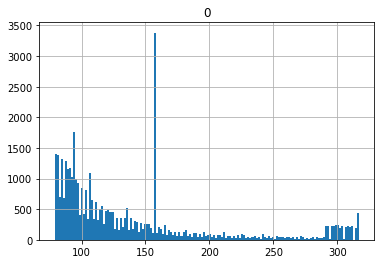

In [20]:
pd.DataFrame(hm[0]).hist(bins = 150)

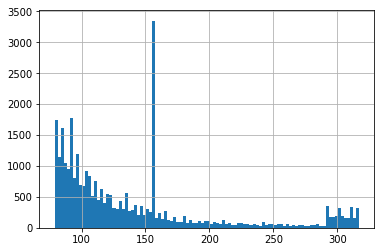

In [21]:
hm[hm[1] == 0][0].hist(bins=100)

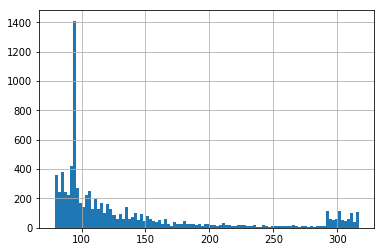

In [23]:
hm[hm[1] == 1][0].hist(bins=100)

In [24]:
pd.DataFrame(data = [lens, y_train])

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,83,93,106,94,85,161,126,119,134,299,...,88,80,132,91,98,94,88,83,101,109
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [25]:
test_dataset = Test_Dataset(X)

In [26]:
lens = [len(test_dataset[i][0]) for i in range(len(test_dataset))]

In [27]:
mda = pd.DataFrame()
mda["path"] = X
mda["lens"] = lens

In [28]:
pd.set_option('max_colwidth', 80)

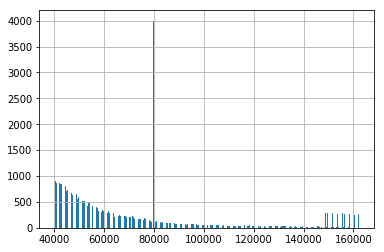

In [29]:
%matplotlib inline
mda["lens"].hist(bins = 500)

In [30]:
wavs = [test_dataset[i][0] for i in range(len(test_dataset))]

In [31]:
from hashlib import sha1

hashes = []
for wav in wavs:
    hashes.append(sha1(wav).hexdigest())

In [32]:
mda["hashes"]=hashes

In [33]:
mda.groupby("hashes")

In [39]:
hashes_set = set(hashes)
white_list = []
for i, wav in enumerate(wavs):
    local = sha1(wav).hexdigest()
    if local in hashes_set:
        hashes_set.discard(local)
        white_list.append(i)

In [46]:
np.save("IDRnD/white_list", np.array(white_list))

In [47]:
np.load("IDRnD/white_list.npy")

array([    0,     1,     2, ..., 49997, 49998, 49999])

In [44]:
X[np.array(white_list)]

array(['/src/workspace/data/files/Training_Data/human/human_00000.wav',
       '/src/workspace/data/files/Training_Data/human/human_00001.wav',
       '/src/workspace/data/files/Training_Data/human/human_00002.wav',
       ...,
       '/src/workspace/data/files/Training_Data/spoof/spoof_39675.wav',
       '/src/workspace/data/files/Training_Data/spoof/spoof_39676.wav',
       '/src/workspace/data/files/Training_Data/spoof/spoof_39677.wav'],
      dtype='<U61')